In [1]:
# Imports
import numpy as np
import pandas as pd
#import hvplot.pandas

In [2]:
%matplotlib inline
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)


Bad key text.latex.preview in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

In [3]:
from tensorflow import random
random.set_seed(2)

In [4]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [5]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [6]:

# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [8]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 7

In [10]:
# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[30 15 40 24 11  8 36]
 [15 40 24 11  8 36 30]
 [40 24 11  8 36 30 44]
 [24 11  8 36 30 44 54]
 [11  8 36 30 44 54 31]] 

y sample values:
[[8260.69043 ]
 [8696.830078]
 [8569.290039]
 [8084.609863]
 [8911.269531]]


In [11]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# Create a MinMaxScaler object
scaler = MinMaxScaler()

In [12]:
# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

MinMaxScaler()

In [13]:
# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

MinMaxScaler()

In [15]:
# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

In [17]:
model = Sequential()

number_units = 5
dropout_fraction = 0.2

In [18]:
# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [19]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 5)              140       
                                                                 
 dropout (Dropout)           (None, 7, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 5)              220       
                                                                 
 dropout_1 (Dropout)         (None, 7, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [44]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
374/374 [==============================] - 7s 19ms/step - loss: 0.0460
Epoch 2/10
374/374 [==============================] - 7s 19ms/step - loss: 0.0472
Epoch 3/10
374/374 [==============================] - 6s 17ms/step - loss: 0.0441
Epoch 4/10
374/374 [==============================] - 7s 18ms/step - loss: 0.0466
Epoch 5/10
374/374 [==============================] - 9s 25ms/step - loss: 0.0478
Epoch 6/10
374/374 [==============================] - 9s 24ms/step - loss: 0.0476
Epoch 7/10
374/374 [==============================] - 10s 26ms/step - loss: 0.0483
Epoch 8/10
374/374 [==============================] - 7s 19ms/step - loss: 0.0462
Epoch 9/10
374/374 [==============================] - 9s 23ms/step - loss: 0.0471
Epoch 10/10
374/374 [==============================] - 10s 26ms/step - loss: 0.0484


In [45]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 12ms/step - loss: 0.1166


0.1166306585073471

In [46]:
# Make some predictions
predicted = model.predict(X_test)

In [47]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [48]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-19,3912.570068,5641.169922
2019-02-20,3924.239990,5889.959473
2019-02-21,3974.050049,6092.637207
2019-02-22,3937.040039,6153.650879
2019-02-23,3983.530029,6187.682129


<AxesSubplot:title={'center':'Fear & Greed'}>

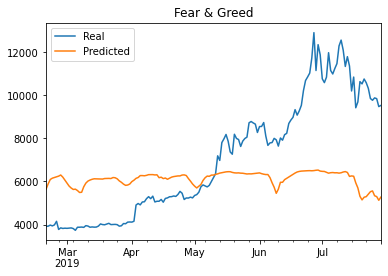

In [49]:
# Plot the real vs predicted values as a line chart
stocks.plot(title='Fear & Greed')

# Which model had the lowest loss - 
## It appears that the Predictive Model using CP had the least "loss" for both the training set and the Test (Predictive) set.
# Determine which model tracks the actual values best over time - 
## It ppears that the Predictive Model using CP over time tracks the target values best, as illustrated in the charts showing Real versus Predicitate data.
# Determine the appropriate Window Size for the model - 
## It appears that the optimum Window Size for both the CP and F&G is 10.